In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Generate batches of tensor image data with real-time data augmentation.
from tensorflow.keras.applications import MobileNetV2 # CNN architecture that works well w/mobile devices as well
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Preprocesses a tensor or Numpy array encoding a batch of images.
from tensorflow.keras.preprocessing.image import img_to_array, load_img 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical # converts a class vector (integers) to a binary class matrix
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from imutils import paths
import cv2
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'

2021-09-07 13:39:51.691407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-07 13:39:51.691446: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Preprocessing the data

In [4]:
# init the initial learning rate, number of epochs to train for, and batch size
init_lr = 1e-4
epochs = 200
bs = 32
image_size = (224,224)

In [5]:
DIRECTORY = r"data"
CATEGORIES = ["with_mask","without_mask"]

In [19]:
print("[INFO] loading images...")

[INFO] loading images...


In [20]:
# splitfolders.ratio('data',output='split_data', seed=1337, ratio=(.8,.1,.1))

## image_dataset_from_directory Pipeline

In [6]:
# create batch datasets

train_ds = image_dataset_from_directory('data',
                                       validation_split=0.2,
                                       subset='training',
                                       seed=1337,
                                       image_size=image_size,
                                       batch_size=bs)
test_ds = image_dataset_from_directory('data',
                                      validation_split=0.2,
                                      subset='validation',
                                      seed=1337,
                                      image_size=image_size,
                                      batch_size=bs)

Found 5989 files belonging to 3 classes.
Using 4792 files for training.
Found 5989 files belonging to 3 classes.
Using 1197 files for validation.


2021-09-07 13:40:09.203157: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-07 13:40:09.203197: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (atlas-GL753VD): /proc/driver/nvidia/version does not exist
2021-09-07 13:40:09.203556: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-09-07 13:40:10.546271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


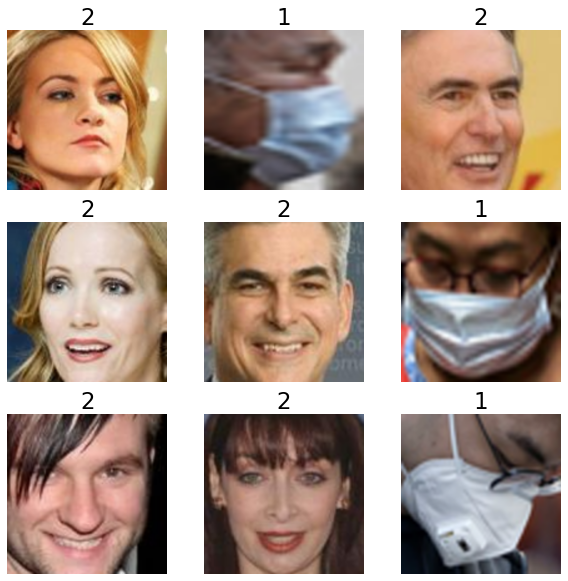

In [7]:
# visualize the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
        plt.savefig('mask_no_mask.png')

## keras_generator Pipeline

## Model Building w/function

In [46]:
def build_model(num_classes, img_size=224):
    # load MobileNetV2 network, ensuring the head FC (Fully Connected) layer sets are left off
    inputs = Input(shape=(img_size,img_size,3))    
    baseModel = MobileNetV2(input_shape=(img_size,img_size,3),weights="imagenet", include_top=False, input_tensor=inputs)
    
    
    # create the head of the model that will be placed on top of the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)

    headModel = Dense(num_classes, activation="softmax")(headModel)
    
    # place the head FC model on top of the base model (this will become the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)

    # lopp over all layers in the base model and freeze them so they will not be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable=False
        
    # compile model
    print("[INFO] compiling model...")
    opt = Adam(lr=init_lr,decay=init_lr / epochs)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model

In [47]:
datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)

In [48]:
train = datagen.flow_from_directory('data',classes=['with_mask','without_mask'],target_size=image_size, batch_size=bs,seed=42,subset='training')
test = datagen.flow_from_directory('data',classes=['with_mask','without_mask'],target_size=image_size, batch_size=bs,seed=42,subset='validation')
# val = datagen.flow_from_directory('split_data/val', class_mode='categorical',target_size=image_size,batch_size=bs)

x_train, y_train = next(train)
x_test,y_test = next(test)
# x_val, y_val = next(val)
type(train)

Found 4792 images belonging to 2 classes.
Found 1197 images belonging to 2 classes.


keras.preprocessing.image.DirectoryIterator

In [49]:
num_classes = len(CATEGORIES)
model = build_model(num_classes)

# train head of the network
print("[INFO] training head...")
H = model.fit(
        x_train,
        y_train,
        steps_per_epoch=(len(x_train) // bs),
        validation_data=(x_test,y_test),
        validation_steps=len(x_test) // bs,
        batch_size=bs,
        epochs=epochs,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  verbose=1,
                                                  patience=6,
                                                  restore_best_weights=True)
)

[INFO] compiling model...
[INFO] training head...
Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.8263 - accuracy: 0.5312 - val_loss: 0.8094 - val_accuracy: 0.3750
Epoch 2/200
1/1 [==============================] - 1s 796ms/step - loss: 0.8735 - accuracy: 0.5000 - val_loss: 0.7971 - val_accuracy: 0.4375
Epoch 3/200
1/1 [==============================] - 1s 792ms/step - loss: 0.8257 - accuracy: 0.4375 - val_loss: 0.7863 - val_accuracy: 0.5000
Epoch 4/200
1/1 [==============================] - 1s 797ms/step - loss: 0.7763 - accuracy: 0.5000 - val_loss: 0.7767 - val_accuracy: 0.5000
Epoch 5/200
1/1 [==============================] - 1s 830ms/step - loss: 0.7804 - accuracy: 0.4688 - val_loss: 0.7680 - val_accuracy: 0.5000
Epoch 6/200
1/1 [==============================] - 1s 833ms/step - loss: 0.7664 - accuracy: 0.5000 - val_loss: 0.7597 - val_accuracy: 0.5000
Epoch 7/200
1/1 [==============================] - 1s 821ms/step - loss: 0.7342 - accuracy: 0.5625 - val_lo

In [340]:
x_test.shape

(32, 224, 224, 3)

In [50]:
ev = model.evaluate(test, batch_size=bs)

38/38 [==============================] - 19s 493ms/step - loss: 0.3915 - accuracy: 0.8647


1st try: loss 0.6 accuracy .75 <br>
2nd try: loss 0.59 accuracy .77 <br>
3rd try: loss 0.57 accuracy .77

In [51]:
print("[INFO] evaluating network...")
predIdxs = model.predict(x_test, batch_size=bs)

[INFO] evaluating network...


In [52]:
# for each img in the testing set, we need to find idx of label w/corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# ! DO CLASSIFICATION REPORT

In [53]:
print(classification_report(np.argmax(y_test, axis=1), predIdxs, target_names=['Mask','No Mask']))

              precision    recall  f1-score   support

        Mask       0.79      1.00      0.88        15
     No Mask       1.00      0.76      0.87        17

    accuracy                           0.88        32
   macro avg       0.89      0.88      0.87        32
weighted avg       0.90      0.88      0.87        32



In [8]:
labels = ['mask_weared_incorrect','with_math','without_mask']
cf_matrix = confusion_matrix(np.argmax(y_test,axis=1), predIdxs)
cm = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Oranges', fmt= ' .2%');
cm.savefig('confusion_matrix.png')
print(cm)

NameError: name 'y_test' is not defined

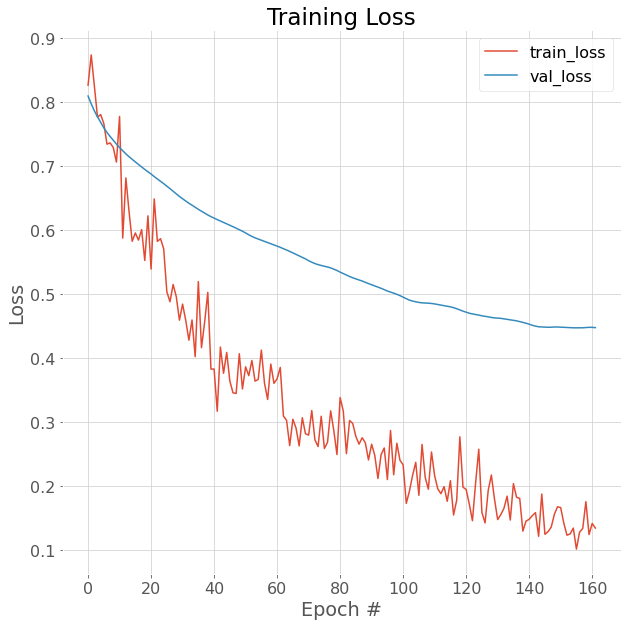

In [55]:
# plot the training loss and accuracy

plt.figure(figsize=(10,10))
plt.plot(H.history['loss'], label='train_loss')
plt.plot(H.history['val_loss'], label='val_loss')

plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.savefig("images/train_loss.png")

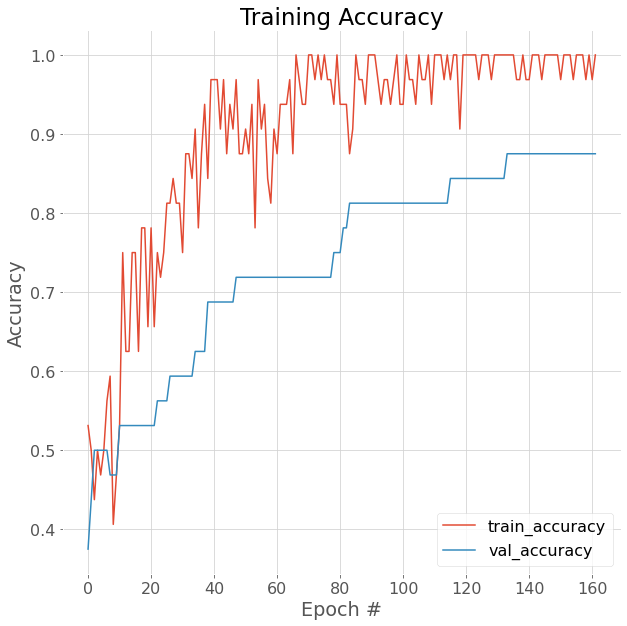

In [56]:
plt.figure(figsize=(10,10))
plt.plot(H.history['accuracy'], label='train_accuracy')
plt.plot(H.history['val_accuracy'], label='val_accuracy')

plt.title('Training Accuracy')
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.savefig("images/train_accuracy.png")


In [58]:
# serialize the model to disk
print('[INFO] saving mask detector model...')
model.save("detect_mask.model", save_format='h5')

[INFO] saving mask detector model...
